In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.api import OLS
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
# %matplotlib inline
import seaborn.apionly as sns

/Users/shreyanshrathore/miniconda3/lib/python3.7/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
gssdata = pd.read_csv("/Users/shreyanshrathore/Desktop/Data Science/2019-CS109A-master/docs/labs/lab07/data/gsshealth18.csv")

print("The dimensions of the data set are:", gssdata.shape[0], "observations and", gssdata.shape[1], "variables." )
gssdata.head()

The dimensions of the data set are: 1569 observations and 10 variables.


,id,health,partyid,age,sex,sexornt,educ,marital,race,income
0,1,good,rep,43.0,male,bisexual/other,14.0,never married,white,NaN
1,2,excellent,dem,74.0,female,hetero,10.0,no longer married,white,NaN
2,5,excellent,rep,71.0,male,hetero,18.0,no longer married,black,NaN
3,6,good,dem,67.0,female,bisexual/other,16.0,no longer married,white,NaN
4,7,good,dem,59.0,female,bisexual/other,13.0,no longer married,black,18.75


In [4]:
gssdata.describe()

print(gssdata['health'].value_counts())
print(gssdata['partyid'].value_counts())
print(gssdata['sex'].value_counts())
print(gssdata['sexornt'].value_counts())
print(gssdata['marital'].value_counts())
print(gssdata['race'].value_counts())

good         771
excellent    359
fair         355
poor          84
Name: health, dtype: int64
dem      708
rep      514
other    347
Name: partyid, dtype: int64
female    872
male      697
Name: sex, dtype: int64
bisexual/other    907
hetero            640
gay                22
Name: sexornt, dtype: int64
married              655
never married        458
no longer married    454
Name: marital, dtype: int64
white    1137
black     259
other     173
Name: race, dtype: int64


In [5]:
gssdata['poorhealth']=1*(gssdata['health']=='poor')
gssdata['poorhealth'].mean()

0.05353728489483748

In [6]:
gssdata.isna().sum()

id              0
health          0
partyid         0
age             2
sex             0
sexornt         0
educ            2
marital         2
race            0
income        661
poorhealth      0
dtype: int64

In [7]:
X = gssdata[['partyid','age','sex','sexornt','educ','marital','race']]

#create dummies (lots of ways to do it, two ways will be in the solutions
# create dummies 2 different ways
X['female'] = 1*(gssdata['sex']=="female")
dummies = pd.get_dummies(X[['marital','race','sexornt','partyid']],drop_first=True)

# add the dummies in via the join command.
X = X.join(dummies)

# let's drop the redundat variables no longer needed since we created the dummies
X = X.drop(['partyid','sex','sexornt','marital','race'],axis=1)

# now check the 'nulls'
X.isna().sum()

/Users/shreyanshrathore/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


age                          2
educ                         2
female                       0
marital_never married        0
marital_no longer married    0
race_other                   0
race_white                   0
sexornt_gay                  0
sexornt_hetero               0
partyid_other                0
partyid_rep                  0
dtype: int64

In [8]:
X['age']=X['age'].fillna(X['age'].median())

# impute the most common education: having a HS degree (13 years)
# see histogram for justification
X['educ']=X['educ'].fillna(13)

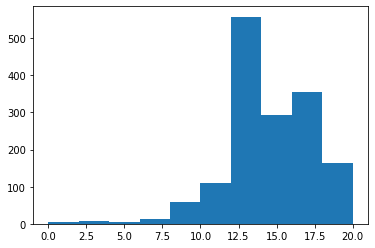

In [9]:
plt.hist(X['educ']);

In [10]:
print(gssdata['age'][pd.isna(gssdata['marital'])])
print(gssdata['age'][pd.isna(gssdata['educ'])])

25      50.0
1478    65.0
Name: age, dtype: float64
529     24.0
1546    75.0
Name: age, dtype: float64


In [11]:
X.isna().sum()

age                          0
educ                         0
female                       0
marital_never married        0
marital_no longer married    0
race_other                   0
race_white                   0
sexornt_gay                  0
sexornt_hetero               0
partyid_other                0
partyid_rep                  0
dtype: int64

In [12]:
from sklearn.model_selection import train_test_split
itrain, itest = train_test_split(range(gssdata.shape[0]), train_size=0.70)

# Note: the train-test split above is for the INDICES for splitting in case we 
# want to use them again in the future...we can have an identical split
X_train = X.loc[itrain]
X_test = X.loc[itest]

y_train = gssdata['poorhealth'][itrain]
y_test = gssdata['poorhealth'][itest]

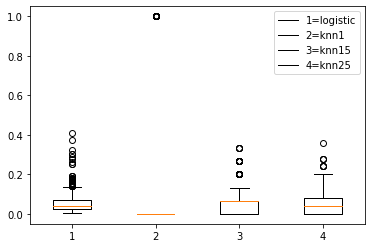

In [13]:
from sklearn.neighbors import KNeighborsClassifier

# unregularized Logistic Regression
logit = sk.linear_model.LogisticRegression(C=100000)
logit.fit(X_train,y_train)

# k-NN for k=1, 15, and 25
knn1 = KNeighborsClassifier(1)
knn1.fit(X_train,y_train)

knn15 = KNeighborsClassifier(15)
knn15.fit(X_train,y_train)

knn25 = KNeighborsClassifier(25)
knn25.fit(X_train,y_train)

logit.predict_proba(X_train)[:,1],

#visualize the predictions via boxplots
plt.boxplot([logit.predict_proba(X_train)[:,1],knn1.predict_proba(X_train)[:,1],
             knn15.predict_proba(X_train)[:,1],knn25.predict_proba(X_train)[:,1]])
plt.legend(["1=logistic","2=knn1","3=knn15","4=knn25"]);

In [14]:
print("Classification accuracy for logistic were: \n Train =",
    logit.score(X_train,y_train),", Test =", logit.score(X_test,y_test))
print("Classification accuracy for knn1 were: \n Train =",
    knn1.score(X_train,y_train),", Test =", knn1.score(X_test,y_test))
print("Classification accuracy for knn15 were: \n Train =",
    knn15.score(X_train,y_train),", Test =", knn15.score(X_test,y_test))
print("Classification accuracy for knn25 were: \n Train =",
    knn25.score(X_train,y_train),", Test =", knn25.score(X_test,y_test))

Classification accuracy for logistic were: 
 Train = 0.9453551912568307 , Test = 0.9490445859872612
Classification accuracy for knn1 were: 
 Train = 1.0 , Test = 0.9044585987261147
Classification accuracy for knn15 were: 
 Train = 0.9453551912568307 , Test = 0.9490445859872612
Classification accuracy for knn25 were: 
 Train = 0.9453551912568307 , Test = 0.9490445859872612


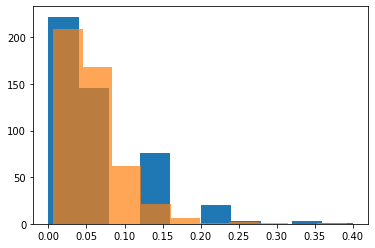

In [15]:
# We plot them for the logistic and knn15
plt.hist(knn15.predict_proba(X_test)[:,1])
plt.hist(logit.predict_proba(X_test)[:,1],alpha=0.7);

In [17]:
from sklearn.metrics import confusion_matrix

# this function may help to manually make confusion table from a different threshold
def t_repredict(est, t, xtest):
    probs = est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred

# Using the logistic model throughout:

# Re-calculating the default confusion matrix
print(confusion_matrix(y_test,t_repredict(knn15,0.5,X_test)))

#And then looking at smaller threshold values: 0.32 and 0.06
print(confusion_matrix(y_test,t_repredict(knn15,0.32,X_test)))
print(confusion_matrix(y_test,t_repredict(knn15),0.06,X_test))

[[447   0]
 [ 24   0]]
[[443   4]
 [ 24   0]]


TypeError: t_repredict() missing 2 required positional arguments: 't' and 'xtest'

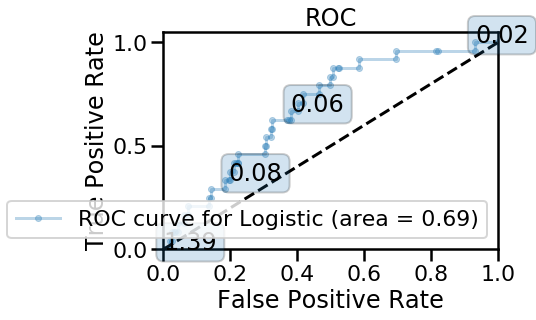

In [18]:
from sklearn.metrics import roc_curve, auc

# a function to make 'pretty' ROC curves for this model
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in range(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax


sns.set_context("poster")
make_roc("Logistic", logit, y_test, X_test, ax=None, labe=20, proba=True, skip=1);